In [1]:
import pandas as pd
import numpy as np
from ProgSnap2 import ProgSnap2Dataset
from ProgSnap2 import PS2
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
import numpy as np
import os
from os import path

In [2]:
semester = 'S19'
BASE_PATH = os.path.join('data', 'Release', semester)
TRAIN_PATH = os.path.join(BASE_PATH, 'Train')
TEST_PATH = os.path.join(BASE_PATH, 'Test')

In [3]:
train_ps2 = ProgSnap2Dataset(os.path.join(TRAIN_PATH, 'Data')) 

In [4]:
# The early dataset will help us to feature extraction,
# but we're not actually predicting anything here
# Note: we could still use this for model training if desired.
early_train = pd.read_csv(os.path.join(TRAIN_PATH, 'early.csv'))
early_train.head()

,SubjectID,AssignmentID,ProblemID,Attempts,CorrectEventually,Label
0,036ad3e516c5bf3a4b3be35b137bcbb8,439.0,1,8,True,False
1,036ad3e516c5bf3a4b3be35b137bcbb8,439.0,3,6,True,False
2,036ad3e516c5bf3a4b3be35b137bcbb8,439.0,5,7,True,False
3,036ad3e516c5bf3a4b3be35b137bcbb8,439.0,12,2,True,True
4,036ad3e516c5bf3a4b3be35b137bcbb8,439.0,13,17,True,False


In [5]:
# The late dataset contains the problems that we're actually predicting for.
# The training portion of it includes labels.
late_train = pd.read_csv(os.path.join(TRAIN_PATH, 'late.csv'))
late_train.head()

,SubjectID,AssignmentID,ProblemID,Label
0,036ad3e516c5bf3a4b3be35b137bcbb8,494.0,41,True
1,036ad3e516c5bf3a4b3be35b137bcbb8,494.0,43,False
2,036ad3e516c5bf3a4b3be35b137bcbb8,494.0,44,False
3,036ad3e516c5bf3a4b3be35b137bcbb8,494.0,46,False
4,036ad3e516c5bf3a4b3be35b137bcbb8,494.0,49,False


In [6]:
X_train_base = late_train.copy().drop('Label', axis=1)
y_train = late_train['Label'].values

In [7]:
problem_encoder = OneHotEncoder().fit(X_train_base[PS2.ProblemID].values.reshape(-1, 1))

In [8]:
problem_encoder.transform(X_train_base[PS2.ProblemID].values.reshape(-1, 1)).toarray()

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [9]:
def extract_instance_features(instance, early_df):
    instance = instance.copy()
    subject_id = instance[PS2.SubjectID]
    early_problems = early_df[early_df[PS2.SubjectID] == subject_id]
    # Extract very naive features about the student
    # (without respect to the problem bring predicted)
    # Number of early problems attempted
    instance['ProblemsAttempted'] = early_problems.shape[0]
    # Percentage of early problems gotten correct eventually
    instance['PercCorrectEventually'] = np.mean(early_problems['CorrectEventually'])
    # Median attempts made on early problems
    instance['MedAttempts'] = np.median(early_problems['Attempts'])
    # Max attempts made on early problems
    instance['MaxAttempts'] = np.max(early_problems['Attempts'])
    # Percentage of problems gotten correct on the first try
    instance['PercCorrectFirstTry'] = np.mean(early_problems['Attempts'] == 1)
    instance = instance.drop('SubjectID')
    return instance

In [10]:
extract_instance_features(X_train_base.iloc[0], early_train)

AssignmentID                  494
ProblemID                      41
ProblemsAttempted              30
PercCorrectEventually           1
MedAttempts                   7.5
MaxAttempts                    30
PercCorrectFirstTry      0.133333
Name: 0, dtype: object

In [11]:
def extract_features(X, early_df, scaler, is_train):
    # First extract performance features for each row
    features = X.apply(lambda instance: extract_instance_features(instance, early_df), axis=1)
    # Then one-hot encode the problem_id and append it
    problem_ids = problem_encoder.transform(features[PS2.ProblemID].values.reshape(-1, 1)).toarray()
    # Then get rid of nominal features
    features.drop([PS2.AssignmentID, PS2.ProblemID], axis=1, inplace=True)
    # Then scale the continuous features, fitting the scaler if this is training
    if is_train:
        scaler.fit(features)
    features = scaler.transform(features)
    
    # Return continuous and one-hot features together
    return np.concatenate([features, problem_ids], axis=1)

In [12]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = extract_features(X_train_base, early_train, scaler, True)

In [13]:
print(X_train.shape)
X_train[:2,]

(4309, 25)


array([[ 0.52055099,  0.55498427,  2.37242355,  0.62909162, -1.09699439,
         1.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.52055099,  0.55498427,  2.37242355,  0.62909162, -1.09699439,
         0.        ,  1.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ]])

## Evaluate the Training Performance of the Model

In [14]:
from sklearn.linear_model import LogisticRegressionCV

model = LogisticRegressionCV()
model.fit(X_train, y_train)
train_predictions = model.predict(X_train)

In [15]:
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score

print(classification_report(train_predictions, y_train))
print('AUC: ' + str(roc_auc_score(train_predictions, y_train)))
print('Macro F1: ' + str(f1_score(train_predictions, y_train, average='macro')))

              precision    recall  f1-score   support

       False       0.17      0.60      0.27       306
        True       0.96      0.78      0.86      4003

    accuracy                           0.76      4309
   macro avg       0.57      0.69      0.56      4309
weighted avg       0.91      0.76      0.82      4309

AUC: 0.687603170171391
Macro F1: 0.5623869292657603


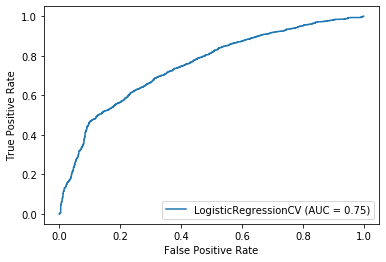

In [16]:
from sklearn.metrics import plot_roc_curve

plot_roc_curve(model, X_train, y_train)

## Evaluate the CV Performance of the Model

In [17]:
from sklearn.model_selection import cross_validate

model = LogisticRegressionCV()
cv_results = cross_validate(model, X_train, y_train, cv=10, scoring=['accuracy', 'f1_macro', 'roc_auc'])
print(f'Accuracy: {np.mean(cv_results["test_accuracy"])}')
print(f'AUC: {np.mean(cv_results["test_roc_auc"])}')
print(f'Macro F1: {np.mean(cv_results["test_f1_macro"])}')

Accuracy: 0.7628263098257163
AUC: 0.749291930067467
Macro F1: 0.5701181525317887


## Predict on the test data (S19)

In [33]:
early_test = pd.read_csv(os.path.join(TEST_PATH, 'early.csv'))
late_test = pd.read_csv(os.path.join(TEST_PATH, 'late.csv'))
X_test = extract_features(late_test, early_test, scaler, False)

In [34]:
X_test.shape

(1454, 25)

In [35]:
model = LogisticRegressionCV()
model.fit(X_train, y_train)
predictions = model.predict(X_test)

In [36]:
predictions

array([ True,  True,  True, ...,  True,  True,  True])

In [37]:
predictions_df = late_test.copy()
predictions_df['Label'] = predictions
predictions_df

,SubjectID,AssignmentID,ProblemID,Label
0,036ad3e516c5bf3a4b3be35b137bcbb8,494.0,41,True
1,036ad3e516c5bf3a4b3be35b137bcbb8,494.0,43,True
2,036ad3e516c5bf3a4b3be35b137bcbb8,494.0,44,True
3,036ad3e516c5bf3a4b3be35b137bcbb8,494.0,46,True
4,036ad3e516c5bf3a4b3be35b137bcbb8,494.0,49,True
...,...,...,...,...
1449,ffb72475a81de0e95b910ffad039f5c2,502.0,64,True
1450,ffb72475a81de0e95b910ffad039f5c2,502.0,70,True
1451,ffb72475a81de0e95b910ffad039f5c2,502.0,71,True
1452,ffb72475a81de0e95b910ffad039f5c2,502.0,112,True


In [38]:
# We don't have the test labels - you have to submit to evaluate it

In [40]:
path = os.path.join('data', 'Prediction', semester)
os.makedirs(path, exist_ok=True)
predictions_df.to_csv(os.path.join(path, 'basic_LR.csv'), index=False)

## Predict on the test data for the _next_ semester (F19)

Here we see if our model will still be useful next semester. Again, we don't have labels for this test dataset, so we'll have to submit to see how well we did.

Later in the year, there will be _training_ data released for F19, which will be tested on a different track (not cross-semester).

In [41]:
F19_TEST_PATH = os.path.join('data', 'Release', 'F19', 'Test')

In [42]:
early_test = pd.read_csv(os.path.join(F19_TEST_PATH, 'early.csv'))
late_test = pd.read_csv(os.path.join(F19_TEST_PATH, 'late.csv'))
X_test = extract_features(late_test, early_test, scaler, False)

In [43]:
X_test.shape

(2377, 25)

In [44]:
model = LogisticRegressionCV()
model.fit(X_train, y_train)
predictions = model.predict(X_test)

In [45]:
predictions

array([ True,  True,  True, ...,  True,  True,  True])

In [46]:
predictions_df = late_test.copy()
predictions_df['Label'] = predictions
predictions_df

,SubjectID,AssignmentID,ProblemID,Label
0,01e96e066eff2e82627dac0493737be2de9bd2f50d6d49...,494,41,True
1,01e96e066eff2e82627dac0493737be2de9bd2f50d6d49...,494,43,True
2,01e96e066eff2e82627dac0493737be2de9bd2f50d6d49...,494,44,True
3,01e96e066eff2e82627dac0493737be2de9bd2f50d6d49...,494,46,True
4,01e96e066eff2e82627dac0493737be2de9bd2f50d6d49...,494,49,True
...,...,...,...,...
2372,ff4cfd98fc176f36fa99b2bc839990d2fd13de4e59b5c4...,502,64,True
2373,ff4cfd98fc176f36fa99b2bc839990d2fd13de4e59b5c4...,502,70,True
2374,ff4cfd98fc176f36fa99b2bc839990d2fd13de4e59b5c4...,502,71,True
2375,ff4cfd98fc176f36fa99b2bc839990d2fd13de4e59b5c4...,502,112,True


In [47]:
# We don't have the test labels - you have to submit to evaluate it

In [48]:
path = os.path.join('data', 'Prediction', 'F19')
os.makedirs(path, exist_ok=True)
predictions_df.to_csv(os.path.join(path, 'basic_LR.csv'), index=False)